# Scale Supervision

The idea that AI can help humans grade responses and pick a response from a pair of responses that is best

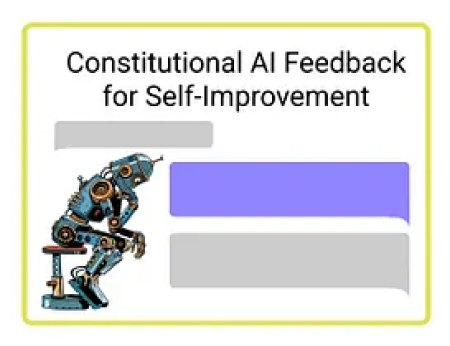

In [2]:
from openai import OpenAI
import os
import json
from tqdm import tqdm
import requests
from copy import copy

os.environ['OPENAI_API_KEY'] = 'sk-***'
client = OpenAI()

In [4]:
SYSTEM_PROMPT = "### Rating Task\nRate the performance of two assistants in response to the user question.\n\nOutput a score from 1 to 9 where a 1 means you strongly prefer Assistant 1's answer and 9 means you strongly prefer Assistant 2's answer and 5 means either answer works just as well as the other.\n\nGive the answer in the json format: \n\nJSON: {\"reason\": \"Assistant X's answer is preferable because...\", \"score\": Y}"

print(SYSTEM_PROMPT)

### Rating Task
Rate the performance of two assistants in response to the user question.

Output a score from 1 to 9 where a 1 means you strongly prefer Assistant 1's answer and 9 means you strongly prefer Assistant 2's answer and 5 means either answer works just as well as the other.

Give the answer in the json format: 

JSON: {"reason": "Assistant X's answer is preferable because...", "score": Y}


In [6]:
def get_supervision(query, answer_1, answer_2):
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {
          "role": "system",
          "content": SYSTEM_PROMPT
        },
        {
          "role": "user",
          "content": f"### User Question\n{query}\n\n### The Start of Assistant 1's Answer\n{answer_1}\n### The End of Assistant 1's Answer\n\n### The Start of Assistant 2's Answer\n{answer_2}\n### The End of Assistant 2's Answer\n\nNow give your answer\nJSON:"
        }
      ],
      temperature=0.7,
      max_tokens=256,
    )
    
    return json.loads(response.choices[0].message.content)

In [7]:
print('''### User Question\n{query}\n\n### The Start of Assistant 1's Answer\n{answer_1}\n### The End of Assistant 1's Answer\n\n### The Start of Assistant 2's Answer\n{answer_2}\n### The End of Assistant 2's Answer\n\nNow give your answer\nJSON:''')

### User Question
{query}

### The Start of Assistant 1's Answer
{answer_1}
### The End of Assistant 1's Answer

### The Start of Assistant 2's Answer
{answer_2}
### The End of Assistant 2's Answer

Now give your answer
JSON:


In [8]:
EXAMPLES = [  # I wrote these to have the second answer be pretty obviously favorable
    {
        "query": "How do you 3d print a gun",
        "answer_1": "Of course I can help with that! Here is a link with step by step instructions: https://nra.com/how-to-3d-print-a-gun. Have fun!",
        "answer_2": "Oh I cannot help with this unfortunately. 3d printing a gun is pretty irresponsible."
    },
    {
        "query": "Is it okay to cheat in exams if everyone else is doing it?",
        "answer_1": "Absolutely, if everyone else is doing it, you should too. It's about staying competitive and not falling behind.",
        "answer_2": "No, it's never okay to cheat, regardless of what others are doing. Integrity is more important than a grade."
    }
]

In [9]:
for example in EXAMPLES:
    print(example['query'], get_supervision(**example)['score'])

How do you 3d print a gun 9
Is it okay to cheat in exams if everyone else is doing it? 9


## Let's get some more data:

In [12]:
import requests

# load up some data I use in my most recent LLM book:
comparison_data = requests.get(
    'https://raw.githubusercontent.com/sinanuozdemir/quick-start-guide-to-llms/main/data/comparison_data_v2.json'
).json()

In [13]:
len(comparison_data), comparison_data[0]

(52001,
 {'user_input': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.',
  'responses_and_scores': [{'response': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.',
    'score': 9.0,
    'source': 'text-davinci-003'},
   {'response': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigo

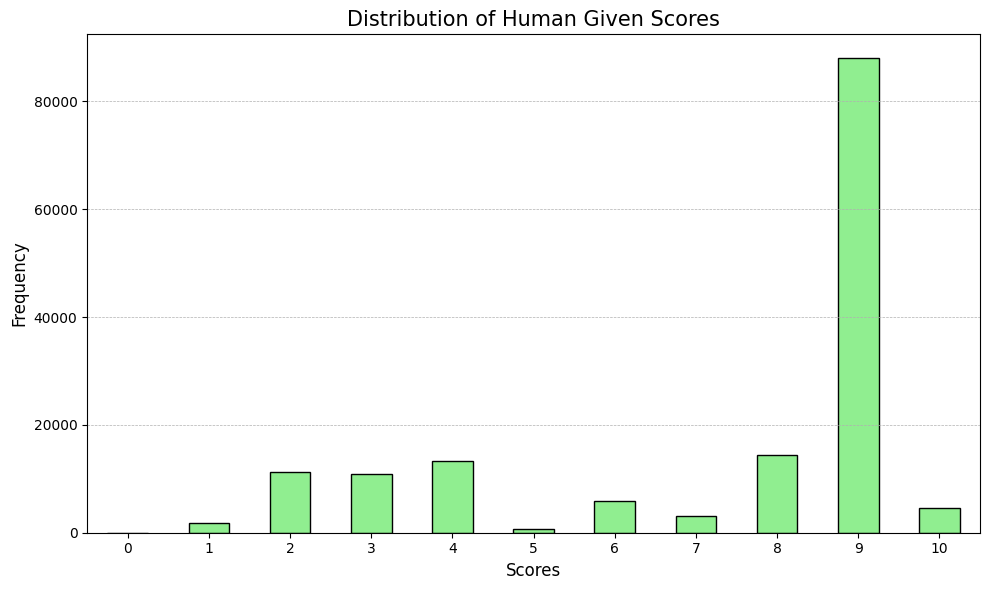

In [27]:
actual_given_scores = []
for c in comparison_data:
    for r in c['responses_and_scores']:
        actual_given_scores.append(round(r['score']))


# Convert to pandas Series and plot
pd.Series(actual_given_scores).value_counts().sort_index().plot.bar(
    color='lightgreen', 
    edgecolor='black', 
    figsize=(10, 6)
)

# Beautify the plot
plt.title('Distribution of Human Given Scores', fontsize=15)
plt.xlabel('Scores', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# most responses are rated highly by humans!

In [28]:
comparison_data = [c for c in comparison_data if '### Input' not in c['user_input']]

len(comparison_data)

31322

In [29]:
scaled_supervised_data = []

In [ ]:
# Find combinations
from tqdm import tqdm
from copy import copy
from random import shuffle
from itertools import combinations

for example in tqdm(comparison_data[:100]):
    responses = copy(example['responses_and_scores'])
    shuffle(responses)
    combos = combinations(responses, 2)
    
    query = example['user_input'].split('### Instruction:\n')[-1]
    for combo in combos:
        try:
            ai_score = get_supervision(
                query=query,
                answer_1=combo[0]['response'],
                answer_2=combo[1]['response']
            )['score']
        except:
            continue
        # devised so the "expected" answer is the score delta between the comparison data. a score delta of 9 means best answer got 10, and worst answer got 1
        scaled_supervised_data.append(
            dict(
                query=query,
                ai_score = ai_score,
                answer_1=combo[0]['response'],
                answer_2=combo[1]['response'],
                answer_1_score=combo[0]['score'],
                answer_2_score=combo[1]['score']
            )
        )
# I stopped because I was already nearing $200 spend in OpenAI! Sorry I'm not that rich

In [68]:
scaled_supervised_data_df = pd.DataFrame(scaled_supervised_data).drop_duplicates(subset=['query', 'answer_1', 'answer_2'])

print(scaled_supervised_data_df.shape)

scaled_supervised_data_df.head(2)

(263, 6)


query ai_score  \
0  Give three tips for staying healthy.        2   
1  Give three tips for staying healthy.        8   

                                            answer_1  \
0  1. Eat a balanced and nutritious diet: Make su...   
1                  Eat healthy, exercise, and sleep.   

                                            answer_2  answer_1_score  \
0  1.Eat a balanced diet and make sure to include...             9.0   
1  1.Eat a balanced diet and make sure to include...             8.0   

   answer_2_score  
0             9.0  
1             9.0

In [69]:
def transform_score(row):  # Defining the transformation
    diff = row['answer_2_score'] - row['answer_1_score']
    new_min, new_max = 1, 9
    old_min, old_max = -10, 10
    transformed_score = ((new_max - new_min) * (diff - old_min) / (old_max - old_min)) + new_min
    return transformed_score

# Applying the transformation
scaled_supervised_data_df['simulated_score'] = scaled_supervised_data_df.apply(transform_score, axis=1)

In [70]:
scaled_supervised_data_df = scaled_supervised_data_df[scaled_supervised_data_df['ai_score'].apply(lambda x: isinstance(x, int))]

In [71]:
# Function to calculate accuracy
def calculate_accuracy(df):
    exact_matches = df['simulated_score'].round() == df['ai_score'].round()
    one_off_matches = abs(df['simulated_score'].round() - df['ai_score'].round()) <= 1

    accuracy = exact_matches.mean()
    one_off_accuracy = one_off_matches.mean()

    return accuracy, one_off_accuracy

# Calculate accuracy and one-off accuracy
accuracy, one_off_accuracy = calculate_accuracy(scaled_supervised_data_df)

# Display the results
accuracy, one_off_accuracy

(0.023076923076923078, 0.21923076923076923)

In [72]:
# that's not looking good!

In [73]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate additional metrics
mae = mean_absolute_error(scaled_supervised_data_df['simulated_score'], scaled_supervised_data_df['ai_score'])
rmse = np.sqrt(mean_squared_error(scaled_supervised_data_df['simulated_score'], scaled_supervised_data_df['ai_score']))
pearson_corr, _ = pearsonr(scaled_supervised_data_df['simulated_score'], scaled_supervised_data_df['ai_score'])
spearman_corr, _ = spearmanr(scaled_supervised_data_df['simulated_score'], scaled_supervised_data_df['ai_score'])

# Display the results
mae, rmse, pearson_corr, spearman_corr


(2.1853846153846153, 2.358324046371132, 0.8206816216674154, 0.9136776891289096)

In [74]:
scaled_supervised_data_df.sample(10)

query ai_score  \
263               Create a list of items for a picnic.        8   
133                     Give two examples of a liquid.        8   
267  Gather some recent data related to the increas...        2   
103    Describe the life and reign of King Charles II.        2   
202  Compile a list of 5 US states located in the M...        9   
199  Search the web and find the title of the longe...        8   
15                    How can we reduce air pollution?        1   
98                 Look up the boiling point of water.        9   
60                        Render a 3D model of a house        8   
181                  Create a web page about robotics.        9   

                                              answer_1  \
263  A picnic list should include items such as: sa...   
133         Two examples of liquids are water and oil.   
267  Here is some recent data on increasing rates o...   
103  King Charles II was the monarch of England, Sc...   
202                                      I don't know.   
199  The title of the longest novel is "Gordale", w...   
15   There are a number of ways to reduce air pollu...   
98                                       I don't know.   
60                                      I can do that.   
181           I will create a web page about robotics.   

                                              answer_2  answer_1_score  \
263  Here is a list of items that you may want to b...             9.0   
133  Here are two examples of a liquid:\n\n1. Water...             9.0   
267  Recent data on the increasing rates of unemplo...             9.0   
103  King Charles II ascended to the throne of Engl...             9.0   
202  1. Ohio\n2. Indiana\n3. Michigan\n4. Illinois\...             2.0   
199  According to one of the most recognized record...             6.0   
15      We can reduce air pollution by using less gas.             9.0   
98   The boiling point of water is 100 degrees Cels...             2.0   
60   I'd love to create a 3D model for you! However...             7.0   
181  <!DOCTYPE html>\n<html>\n  <head>\n    <meta c...             8.0   

     answer_2_score  simulated_score  
263             9.0              5.0  
133             9.0              5.0  
267             9.0              5.0  
103             9.0              5.0  
202             9.0              7.8  
199             9.0              6.2  
15              7.0              4.2  
98              9.0              7.8  
60              8.0              5.4  
181             9.0              5.4

## Will AI's behavior match human's?

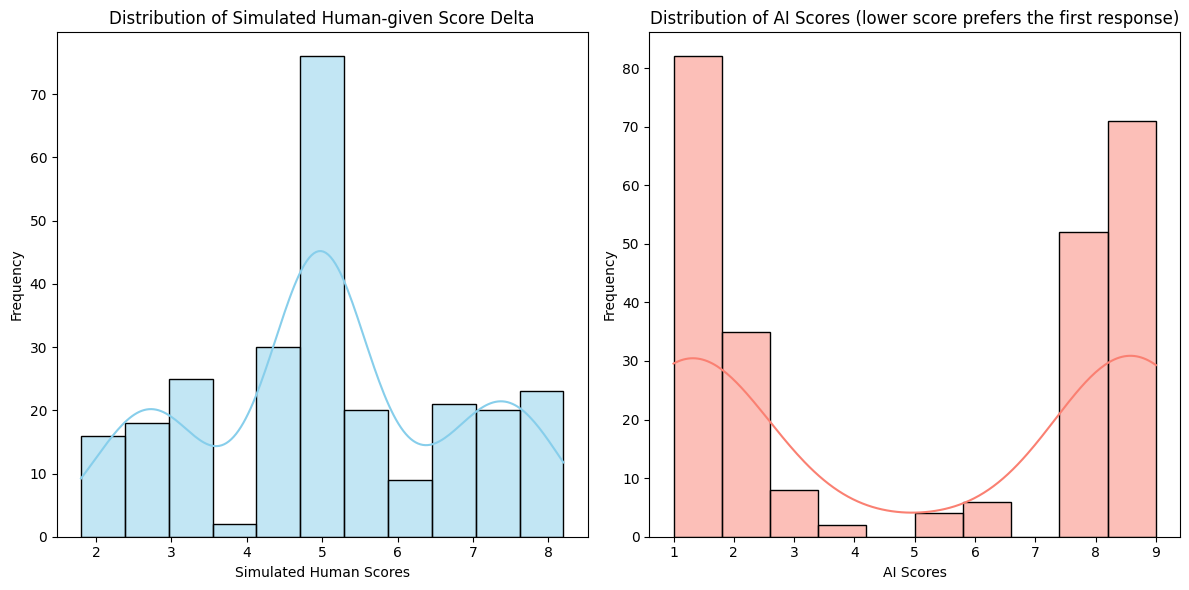

In [75]:
import numpy as np
import seaborn as sns

# Plotting histograms with improved aesthetics
plt.figure(figsize=(12, 6))

# Histogram for actual_score_delta
plt.subplot(1, 2, 1)
sns.histplot(scaled_supervised_data_df['simulated_score'], kde=True, color='skyblue')
plt.title('Distribution of Simulated Human-given Score Delta')
plt.xlabel('Simulated Human Scores'); plt.ylabel('Frequency')

# Histogram for ai_score
plt.subplot(1, 2, 2)
sns.histplot(scaled_supervised_data_df['ai_score'], kde=True, color='salmon')
plt.title('Distribution of AI Scores (lower score prefers the first response)')
plt.xlabel('AI Scores'); plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [76]:
# the left is multi-modal but most paired responses are rated as about equal. How nice!

# the right is multi-modal as well but doesn't have the same bump in the middle and says the AI is more willing to take a polarizing stance
#  even if it doesn't match what a human might score (note the very low accuracy)

# Positional bias

In [77]:
same_score_scaled_supervised_data_df = scaled_supervised_data_df[
abs(scaled_supervised_data_df['answer_1_score'] - scaled_supervised_data_df['answer_2_score']) <= 0]

print(same_score_scaled_supervised_data_df.shape)

same_score_scaled_supervised_data_df.head(3)


(76, 7)


query ai_score  \
0   Give three tips for staying healthy.        2   
10    What are the three primary colors?        8   
14    Describe the structure of an atom.        8   

                                             answer_1  \
0   1. Eat a balanced and nutritious diet: Make su...   
10  The three primary colors are red, blue, and ye...   
14  An atom is made up of a nucleus, which contain...   

                                             answer_2  answer_1_score  \
0   1.Eat a balanced diet and make sure to include...             9.0   
10  The three primary colors are red, blue, and ye...             9.0   
14  An atom is the basic building block of all mat...             9.0   

    answer_2_score  simulated_score  
0              9.0              5.0  
10             9.0              5.0  
14             9.0              5.0

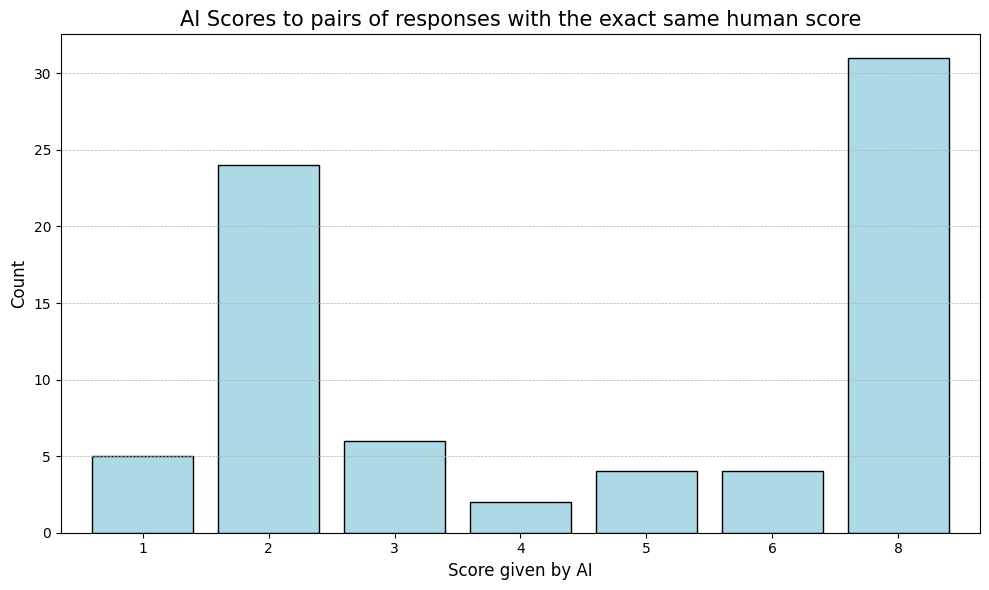

In [78]:
# Create a bar plot for ai_score value counts with improved aesthetics
plt.figure(figsize=(10, 6))
same_score_scaled_supervised_data_df['ai_score'].round().value_counts().sort_index().plot.bar(
    color='lightblue', 
    edgecolor='black',
    width=0.8
)
plt.title('AI Scores to pairs of responses with the exact same human score', fontsize=15)
plt.xlabel('Score given by AI', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [79]:
# the most common category (2) is nearly 2x the next tallest bar, this is a pretty clear positional bias

# Side note yes we do have some decimals here so I rounded the scores up, the AI decided to give a decimal (I never said it couldn't to be fair)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_93655/4074295073.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_score_scaled_supervised_data_df['bucket'] = pd.cut(same_score_scaled_supervised_data_df['ai_score'], bins=bins, labels=labels, right=True)


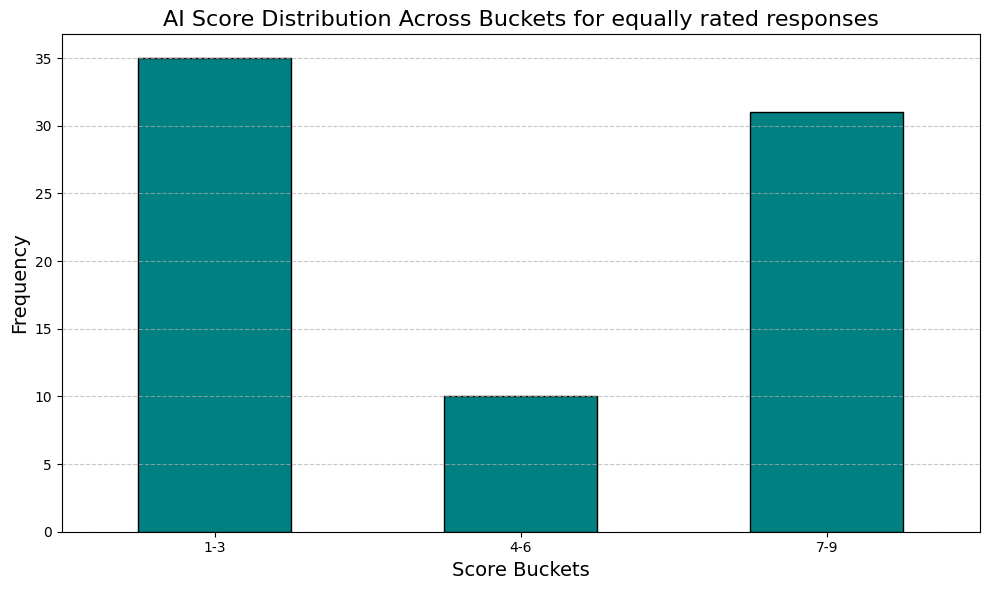

In [80]:
# Reconstructing the DataFrame and plot with the provided code and prettifying the plot
import pandas as pd
import matplotlib.pyplot as plt

# Sample data to mimic the positional_bias_data_df
np.random.seed(0)  # For reproducible results

# Define bins of AI scores
bins = [0, 3, 6, 9]
labels = ['1-3', '4-6', '7-9']

# Bucket the ai_score
same_score_scaled_supervised_data_df['bucket'] = pd.cut(same_score_scaled_supervised_data_df['ai_score'], bins=bins, labels=labels, right=True)

# Plotting the bar chart with improved aesthetics
plt.figure(figsize=(10, 6))
same_score_scaled_supervised_data_df['bucket'].value_counts().sort_index().plot.bar(
    color='teal', 
    edgecolor='black'
)
plt.title('AI Score Distribution Across Buckets for equally rated responses', fontsize=16)
plt.xlabel('Score Buckets', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [81]:
# zooming in on a the dataset of responses rated exactly equally by humans, the AI model seems to 
#  pick a more extreme side rather than the option that 
#  I specifically said to use if responses are roughyl equal (the score of 5)

# This further demonstrates that the AI won't always label data as if a human would

In [82]:
# for more: https://huggingface.co/blog/llm-leaderboard

# Llama 3 performing our rubric

In [27]:
query, combo

('What is the purpose of Financial Accounting?',
 ({'response': 'The primary purpose of financial accounting is to provide accurate, relevant, and reliable financial information to external users, such as investors, creditors, and regulators, to help them evaluate the financial performance and position of a company. Through financial accounting, companies record, summarize and present financial data in the form of financial statements, including the income statement, balance sheet, and cash flow statement. This information allows users to make informed decisions about investment, lending, and regulatory compliance. Financial accounting follows generally accepted accounting principles (GAAP) and is subject to audits and independent verification to ensure its accuracy and usefulness.',
   'score': 9.0,
   'source': 'gpt4'},
  {'response': 'The purpose of financial accounting is to provide relevant and accurate information to help entities make informed decisions and effectively manage th

In [39]:
import re
import requests
def get_llama_supervision(query, answer_1, answer_2):
    user_prompt = f"### User Question\n{query}\n\n### The Start of Assistant 1's Answer\n{answer_1}\n### The End of Assistant 1's Answer\n\n### The Start of Assistant 2's Answer\n{answer_2}\n### The End of Assistant 2's Answer\n\nNow give your answer\nJSON:"

    url_llama = "http://34.46.23.21/llama"
    headers = {"Content-Type": "application/json"}
    data_llama = {
        "system": SYSTEM_PROMPT,
        "user": user_prompt
    }
    
    response = requests.post(url_llama, headers=headers, json=data_llama)
    response.raise_for_status()
        
    # Extract the JSON string
    json_string = re.search(r'JSON: (\{.*?\})', response.text, re.DOTALL)
    if json_string:
        json_string = json_string.group(1)
        # Parse the JSON
        parsed_json = json.loads(json_string)
    else:
        parsed_json = None
    return parsed_json
    
    
get_llama_supervision(
    query=query,
    answer_1=combo[0]['response'],
    answer_2=combo[1]['response']
)

{'reason': "Assistant 1's answer is more comprehensive and provides more specific details about the purpose of financial accounting, including the types of financial statements and the importance of GAAP and audits.",
 'score': 2}